This notebook will show comparison graphs between a selected model from the simulation and predictions from the random forest model using the same input conditions. Below is the prediction class.

In [1]:
import numpy as np
from joblib import load

class DustPredictor:
    
    def __init__(self, model_path):
        self.model = load(model_path)


    def predict(self, r, mstar, alpha, d2g, sigma, tgas, t, delta_t, input_bins):
        """
        r (float): distance from central star
        mstar (float): mass of star in the system
        alpha (float): turblance
        d2g (float): dust to gas ratio
        sigma (float): the surface density of the gas in the model (in g/cm^2)
        tgas (float): temperature of the gas
        t (int): absolute time in seconds
        delta_t (int): time in seconds in the future to predict for
        input_bins (array length 171): 171 length array of dust densities
        model (sklearn class): pretrained random forest model

        Returns (array length 171): 171 length array of the predicted dust densities
        """


        input_params = [r, mstar, alpha, d2g, sigma, tgas]
        input_bins_sum = np.sum(input_bins)
        #Normalize the input bins and zero out normalized bins less than 10^-30\n",
        normalized_input_bins = []
        for i in range(len(input_bins)):
            new_input_bin = np.sum(input_bins[i]) / input_bins_sum
            if new_input_bin < 1e-30:
                new_input_bin = 0
            normalized_input_bins.append(new_input_bin)

        # Input features
        X = np.concatenate([input_params,normalized_input_bins,[t, delta_t]])


        prediction = self.model.predict(X.reshape(1, -1))
        #display(prediction)
        
        # Unnormalize the prediction by multiplying each bin by the input mass
        prediction *= input_bins_sum
        #display(prediction)
        return prediction.flatten()




Swap comments to use the smaller model rather than the larger model

In [2]:
dust_predictor = DustPredictor('/project/SDS-capstones-kropko21/uva-astronomy-models/rf-model-large.joblib')
#dust_predictor = DustPredictor('/project/SDS-capstones-kropko21/uva-astronomy-models/rf-model-small.joblib')

/home/keh4nb/.local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Run the cell to prepere the evaluation function

In [3]:
import os
import json
from scipy.spatial.distance import jensenshannon
from matplotlib import pyplot as plt

#From: https://stackoverflow.com/a/25628397
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def evaluate_preds_with_sim(model_num, step_size=10, max_index=55):
    """
    Plots snapshots from the selected model run and plots the predictions using the random forest model
    model_num: Number of model run from v2 fata (0-10000)
    step_size: The step size between each snapshots of the model run
    max_index: The maximum snapshot to consider
    
    """

    # Open the associated files with the specified model_num
    version = "v2"
    root_data_path = f"/project/SDS-capstones-kropko21/dust_models/dust_coag_{version}"

    data_set = str(model_num).zfill(5)
    data_dir = f"{root_data_path}/data_{data_set}"
    input_params = None

    # Open and extract the input parameters
    with open(os.path.join(root_data_path, f"model_dict_{version}.json")) as f:
        model_dict = json.load(f)
        input_dict = model_dict[data_set]
        print(input_dict)

    try:
        # `rho_dat`: The dust mass density (in g/cm^3) in each particle size/bin at a given snapshot in time. This is the main "output", i.e., the primary result, of any given model.
        rhod = np.loadtxt(os.path.join(data_dir,"rho_d.dat"))
        # Replace NaNs with 0s
        rhod = np.nan_to_num(rhod)
        # Replace negative values with 0s
        rhod = np.where(rhod<0, 0, rhod) 

         # `a_grid.dat`: The dust particle size in each "bin" in centimeters.
        a_grid = np.loadtxt(os.path.join(data_dir, 'a_grid.dat'))

        # `time.dat`: The time of each snapshot (in seconds).
        time = np.loadtxt(os.path.join(data_dir, "time.dat"))
    except Exception as e:
        print(f'model {d} skipped')
        import traceback
        print(traceback.print_exc())
    
    # Set the figure size
    fig = plt.figure(figsize=(8,6))

    # Generate the indexes we are going to use based off the step size and max index
    idxs = list(range(0, min(len(rhod-1),max_index), step_size))
    # If the simulation only has the initial index 0, add the last one
    if len(idxs) == 1:
        idxs.append(len(rhod)-1)
    
    # Plot the true simulated values
    cmap = get_cmap(len(idxs))
    for i,idx in enumerate(idxs):
        plt.plot(rhod[idx], color=cmap(i), label=idx)
    plt.xticks([])
    plt.title("Dust Sim")
    plt.legend(loc="upper left")
    plt.show()
    
    # Make predictions using the random forest model
    pred_outputs = []
    for i in range(1, len(idxs)):
        prev_idx = idxs[i-1]
        idx = idxs[i]
        if i == 1:
            input_bins = rhod[0]
        else:
            # Swap these lines to use the real input distribution than the previous output as the input
            input_bins = pred_output
            #input_bins = rhod[idx]

        t = time[prev_idx]

        # Difference of time in seconds between two snapshots
        delta_t = time[idx] - t

        pred_output = dust_predictor.predict(input_dict['R'], input_dict['Mstar'], input_dict['alpha'],input_dict['d2g'], input_dict['sigma'], input_dict['Tgas'], t, delta_t, input_bins)
        pred_outputs.append(pred_output)
        print(f"Entropy: {jensenshannon(rhod[idx], pred_output)} for snapshot {idx}")
        
    fig = plt.figure(figsize=(8,6))
    # Plot the results of the predictions
    plt.plot(rhod[0], color=cmap(0), label='0')
    for idx, pred in enumerate(pred_outputs):
        plt.plot(pred, color=cmap(idx+1), label=idxs[idx+1])
    plt.xticks([])
    #plt.ylim(0, 2e-14) 
    plt.legend(loc="upper left")
    plt.title("ML Model")
    plt.show()

Call the evaluation function and two graphs will be plotted. The first arguement is the model number. It takes an optional second arguement for the step size between snapshots to plot and an optional third arguement which is the max snapshot index it will go up to.

{'tag': '09816', 'R': 439.38752621208494, 'Mstar': 1.0, 'alpha': 0.01, 'd2g': 0.001, 'sigma': 0.18457689506039313, 'Tgas': 4.7706344303819845, 'm_min': 1e-15, 'm_max': 100.0, 'input': 'data/input_09816.nml', 'data': 'data'}


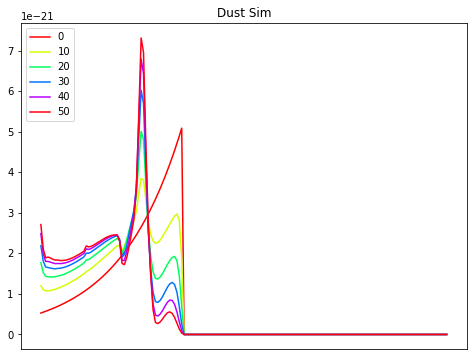

Entropy: 0.10023884037251463 for snapshot 10
Entropy: 0.19547611951270277 for snapshot 20
Entropy: 0.18019987328474227 for snapshot 30
Entropy: 0.14436550553983718 for snapshot 40
Entropy: 0.10126157224501518 for snapshot 50


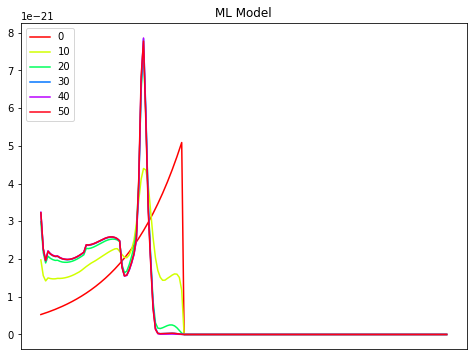

In [4]:
#evaluate_preds_with_sim(9219)
#evaluate_preds_with_sim(1021)
evaluate_preds_with_sim(9816)
#evaluate_preds_with_sim(2801)
